<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe30338-2021](https://jckantor.github.io/cbe30338-2021);
content is available [on Github](https://github.com/jckantor/cbe30338-2021.git).*


<!--NAVIGATION-->
< [5.1 Linear Production Model](https://jckantor.github.io/cbe30338-2021/05.01-Linear-Production-Model.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [5.3 Gasoline Blending](https://jckantor.github.io/cbe30338-2021/05.03-Gasoline-Blending.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/05.02-Linear-Blending-Problem.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/05.02-Linear-Blending-Problem.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 5.2 Linear Blending Problem

This notebook introduces simple material blending problems, and outlines a multi-step procedure for creating and solving models for these problems using CVXPY.

### 5.2.1 Learning Goals

* Linear Blending problems
    * Frequently encountered in material blending 
    * Models generally consist of linear mixing rules and mass/material balances
    * Decision variables are indexed by a set of raw materials
    
    
* Modeling and solving linear blending problems in CVXPY
    * Step 1. Coding problem data. Nested dictionaries or Pandas dataframes.
    * Step 2. Create index set. Use .keys() with nested dictionaries, or .index with Pandas dataframes.
    * Step 3. Create a dictionary of decision variables. Add any pertinent qualifiers or constraints for individual variables such as lower and upper bounds, non-negativity, variable names.
    * Step 4. Create an expression defining the problem objective.
    * Step 5. Create a one or more lists of problem constraints.
    * Step 6. Create the problem object from the objectives and constraints.
    * Step 7. Solve and display the solution.

## 5.2.1 Problem Statement (Jenchura, 2017)

A brewery receives an order for 100 gallons of 4% ABV (alchohol by volume) beer. The brewery has on hand beer A that is 4.5% ABV that cost \\$0.32 per gallon to make, and beer B that is 3.7% ABV and cost \\$0.25 per gallon. Water can also be used as a blending agent at a cost of \\$0.05 per gallon. Find the minimum cost blend that meets the customer requirements.

## 5.2.2 Solving optimization problems with CVXPY

The blending problem described above is relatively simple, it can be solved in CVXPY using no more than `cp.Variable()`, `cp.Minimize()`, and `cp.Problem()` as demonstrated below.

In [4]:
import numpy as np
import cvxpy as cp

### 5.2.2.1 Step 1. Coding Problem Data as a Python Dictionary

The first step is to represent the problem data in a generic manner that could be extended to include additional blending components.  Here we use a dictionary of raw materials, each key denoting a unique blending agent. For each key there is a second level dictionary containing attributes of the blending component. This nested "dictionary of dictionaries" organization is a useful of organizing tabular data for optimization problems.

In [28]:
data = {
    'A': {'abv': 0.045, 'cost': 0.32},
    'B': {'abv': 0.037, 'cost': 0.25},
    'W': {'abv': 0.000, 'cost': 0.05},
}
print(data)

{'A': {'abv': 0.045, 'cost': 0.32}, 'B': {'abv': 0.037, 'cost': 0.25}, 'C': {'abv': 0.03, 'cost': 0.09}, 'W': {'abv': 0.0, 'cost': 0.05}}


### 5.2.2.2 Step 2. Identifying index sets

The objectives and constraints encountered in optimization problems often include sums over a set of objects. In the case, we will need to create sums over the set of raw materials in the blending problem.

In [29]:
components = set(data.keys())
print(components)

{'C', 'A', 'W', 'B'}


### 5.2.2.3 Step 3. Create decision variables

In [30]:
x = {c: cp.Variable(nonneg=True) for c in components}
print(x)

{'C': Variable((), nonneg=True), 'A': Variable((), nonneg=True), 'W': Variable((), nonneg=True), 'B': Variable((), nonneg=True)}


### 5.2.2.4 Step 4. Objective Function

If we let subscript $c$ denote a blending component from the set of blending components $C$, and denote the volume of $c$ used in the blend as $x_c$, the cost of the blend is

\begin{align}
\mbox{cost} & = \sum_{c\in C} x_c P_c
\end{align}

where $P_c$ is the price per unit volume of $c$. Using the Python data dictionary defined above, the price $P_c$ is given by `data[c]['cost']`.

In [31]:
total_cost = sum([x[c]*data[c]["cost"] for c in components])
objective = cp.Minimize(total_cost)
print(objective)

minimize var8441 @ 0.09 + var8442 @ 0.32 + var8443 @ 0.05 + var8444 @ 0.25


### 5.2.2.5 Step 5. Constraints

In [32]:
V = 100
abv = 0.040
constraints = []

#### 5.2.2.5.1 Volume Constraint

The customer requirement is produce a total volume $V$. Assuming ideal solutions, the constraint is given by

\begin{align}
V &  = \sum_{c\in C} x_c
\end{align}

where $x_c$ denotes the volume of component $c$ used in the blend.

In [33]:
constraints.append(V == sum(x[c] for c in components))

#### 5.2.2.5.2 Product Composition Constraint

The product composition is specified as 4% alchohol by volume. Denoting this as $\bar{A}$, the constraint may be written as

\begin{align}
\bar{A} & = \frac{\sum_{c\in C}x_c A_c}{\sum_{c\in C} x_c}
\end{align}

where $A_c$ is the alcohol by volume for component $c$. As written, this is a nonlinear constraint. Multiplying both sides of the equation by the denominator yields a linear constraint

\begin{align}
\bar{A}\sum_{c\in C} x_c & = \sum_{c\in C}x_c A_c
\end{align}

A final form for this constraint can be given in either of two versions. In the first version we subtract the left-hand side from the right to give

\begin{align}
0 & = \sum_{c\in C}x_c \left(A_c - \bar{A}\right) & \mbox{ Version 1 of the linear blending constraint}
\end{align}

Alternatively, the summation on the left-hand side corresponds to total volume. Since that is known as part of the problem specification, the blending constraint could also be written as

\begin{align}
\bar{A}V & = \sum_{c\in C}x_c A_c  & \mbox{ Version 2 of the linear blending constraint}
\end{align}

Which should you use? Either will generally work well. The advantage of version 1 is that it is fully specified by a product requirement $\bar{A}$, which is sometimes helpful in writing elegant Python code.

In [34]:
constraints.append(0 <= sum(x[c]*(data[c]['abv'] - abv) for c in components))

### 5.2.2.6 Step 6. Create CVXPY Problem object

In [35]:
problem = cp.Problem(objective, constraints)

### 5.2.2.7 Step 7. Solve problem and display solution

In [36]:
problem.solve()

print(f"Minimum cost to produce {V} gallons at ABV={abv} = ${total_cost.value:5.2f}")
for c in sorted(components):
    print(f"{c}: {x[c].value:5.2f} gallons")

Minimum cost to produce 100 gallons at ABV=0.04 = $24.33
A: 66.67 gallons
B:  0.00 gallons
C: 33.33 gallons
W:  0.00 gallons


## 5.2.3 Parametric Studies

An important use of optimization models is to investigate how operations depend on critical parameters. For example, for this blending problem we may be interested in questions like:

* How does the operating cost change with product alcohol content?
* What is the cost of producing one more gallon of product?
* What if the supply of a raw material is constrained?
* What if we produce two products rather than one?
* How much would be pay for raw materials with different specifications

### 5.2.3.1 Consolidating

To enable parametric studies, our first step is to consolidate all of the prior development into a single cell, and to consolidate the 

In [63]:
import numpy as np
import cvxpy as cp
import pandas as pd

def brew_blend(volume, abv, data):
    
    # create set of components
    components = set(data.keys())
    
    # create variables
    x = {c: cp.Variable(nonneg=True, name=c) for c in components}
    
    # create objective function
    total_cost = sum(x[c]*data[c]['cost'] for c in components)
    
    # create list of constraints
    constraints = [
        volume == sum(x[c] for c in components),
        0 == sum(x[c]*(data[c]['abv'] - abv) for c in components)
    ]
    
    # create and solve problem
    problem = cp.Problem(cp.Minimize(total_cost), constraints)
    problem.solve()
    
    # return results
    min_cost = problem.value
    optimal_blend = {c: x[c].value for c in components}
    return min_cost, optimal_blend

# problem data
data = {
    'A': {'abv': 0.045, 'cost': 0.32},
    'B': {'abv': 0.037, 'cost': 0.25},
    "C": {'abv': 0.030, 'cost': 0.09},
    'W': {'abv': 0.000, 'cost': 0.05},
}

# product requirement
volume = 100
abv = 0.04

# optimal solution
min_cost, optimal_blend = brew_blend(volume, abv, data)

# display solutoin
print(f"Minimum cost to produce {volume} gallons at ABV={abv} = ${min_cost:5.2f}")
for c in sorted(optimal_blend.keys()):
    print(f"{c}: {optimal_blend[c]:5.2f}")

print(optimal_blend)
df = pd.DataFrame(optimal_blend, index=optimal_blend.keys())
df

Minimum cost to produce 100 gallons at ABV=0.04 = $24.33
A: 66.67
B:  0.00
C: 33.33
W:  0.00
{'C': 33.333333327922226, 'A': 66.6666666671207, 'W': 1.1218738137027075e-09, 'B': 3.835217640330187e-09}


,C,A,W,B
C,33.333333,66.666667,1.121874e-09,3.835218e-09
A,33.333333,66.666667,1.121874e-09,3.835218e-09
W,33.333333,66.666667,1.121874e-09,3.835218e-09
B,33.333333,66.666667,1.121874e-09,3.835218e-09


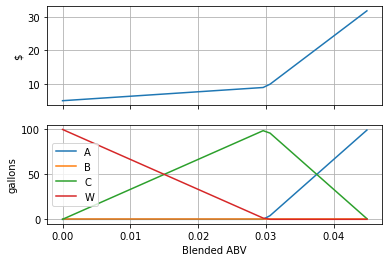

In [38]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

data = {
    'A': {'abv': 0.045, 'cost': 0.32},
    'B': {'abv': 0.037, 'cost': 0.25},
    "C": {'abv': 0.030, 'cost': 0.09},
    'W': {'abv': 0.000, 'cost': 0.05},
}

# gather results for a range of abv values
abv = np.linspace(0, 0.05)
results = [brew_blend(volume, a, data) for a in abv]

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(abv, [cost for cost, values in results])
ax[0].set_ylabel("$")
ax[0].grid(True)

for c in sorted(data.keys()):
    ax[1].plot(abv, [values[c] for cost, values in results], label=c)
ax[1].set_xlabel('Blended ABV')
ax[1].set_ylabel('gallons')
ax[1].legend()
ax[1].grid(True)

<hr>

**Study Question:** 

<!--NAVIGATION-->
< [5.1 Linear Production Model](https://jckantor.github.io/cbe30338-2021/05.01-Linear-Production-Model.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [5.3 Gasoline Blending](https://jckantor.github.io/cbe30338-2021/05.03-Gasoline-Blending.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/05.02-Linear-Blending-Problem.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/05.02-Linear-Blending-Problem.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>